in this note book we implement excercise 2.


we will be working interactivley:

load variables into global and interact in jupyter. only things work and are understood, do we move to classes and fucntions

# imports and setup

In [1]:
import sys, os
sys.path.append(os.getcwd())

In [2]:
import numpy as np
import faiss
from helpers import *
from pathlib import Path


## brief summary of methods in helpers

**Helper functions:**
- `decision_tree_demo()`: Demo of training/predicting with DecisionTreeClassifier
- `loading_random_forest()`: Shows how to initialize RandomForestClassifier with 300 trees, max_depth=6
- `loading_xgboost()`: Shows how to initialize XGBClassifier with 300 trees, max_depth=6, lr=0.1
- `plot_decision_boundaries(model, X, y, title)`: Visualizes classifier decision boundaries on 2D space
- `knn_examples(X_train, Y_train, X_test, Y_test)`: Demo of training/predicting with KNNClassifier
- `read_data_demo(filename)`: Reads CSV and returns numpy array + column names

## data overview

**Task:** Create paths to all CSV files (train.csv, validation.csv, test.csv, AD_test.csv). Print first few rows of train and AD_test. Print shapes of all datasets.

In [3]:
train_path = Path('train.csv')
val_path = Path('validation.csv')
test_path = Path('test.csv')
ad_test_path = Path('AD_test.csv')

train_path, val_path, test_path, ad_test_path

(WindowsPath('train.csv'),
 WindowsPath('validation.csv'),
 WindowsPath('test.csv'),
 WindowsPath('AD_test.csv'))

In [4]:
train_data, train_cols = read_data_demo(train_path)
ad_test_data, ad_test_cols = read_data_demo(ad_test_path)

print(f"Train data first 5 rows:\n{train_data[:5]}\n")
print(f"Train columns: {train_cols}\n")
print(f"AD_test data first 5 rows:\n{ad_test_data[:5]}\n")
print(f"AD_test columns: {ad_test_cols}")

Train data first 5 rows:
[[-90.2232  33.1831  22.    ]
 [-91.3027  36.0799   1.    ]
 [-95.7114  32.6776  40.    ]
 [-93.5819  42.3102   9.    ]
 [-81.23    40.8873  32.    ]]

Train columns: ['long', 'lat', 'state']

AD_test data first 5 rows:
[[34.78   32.08  ]
 [35.2066 31.7784]
 [34.9992 32.8192]
 [34.8    31.95  ]
 [34.8864 32.0889]]

AD_test columns: ['long', 'lat']


# part 1: KNN iplementation

specification notes

Algorithm 1: kNN Classification

Data: Training dataset Xtrain = {(xi, yi)}N

i=1, where xi ∈ R2 is the

feature vector and yi corresponds to its class label; Test instance
ˆxtest; Number of neighbors k.

Result: Predicted class label ˆytest for the test instance.
for each training instance (xi, yi) do

Calculate the distance di between xi and xtest.

Sort the distances di in ascending order and select the first k instances.
for each class c do

Count the occurrences of c in the selected k instances.
Assign the class label ˆytest to the one with the highest count.
return ˆytest



In [5]:

class KNNClassifier:
    def __init__(self, k, distance_metric='l2'):
        self.k = k
        self.distance_metric = distance_metric
        self.X_train = None
        self.Y_train = None

    def fit(self, X_train, Y_train):
        """
        Update the kNN classifier with the provided training data.

        Parameters:
        - X_train (numpy array) of size (N, d): Training feature vectors.
        - Y_train (numpy array) of size (N,): Corresponding class labels.
        """
        self.X_train = X_train.astype(np.float32)
        self.Y_train = Y_train
        d = self.X_train.shape[1]
        if self.distance_metric == 'l2':
            self.index = faiss.index_factory(d, "Flat", faiss.METRIC_L2)
        elif self.distance_metric == 'l1':
            self.index = faiss.index_factory(d, "Flat", faiss.METRIC_L1)
        else:
            raise NotImplementedError
        pass
        self.index.add(self.X_train)

    def predict(self, X):
        """
        Predict the class labels for the given data.

        Parameters:
        - X (numpy array) of size (M, d): Feature vectors.

        Returns:
        - (numpy array) of size (M,): Predicted class labels.
        """
        X = X.astype(np.float32)
        distances, indices = self.index.search(X, self.k)
        neighbor_labels = self.Y_train[indices]
        return np.array([np.bincount(row.astype(int)).argmax() for row in neighbor_labels])

    def knn_distance(self, X):
        """
        Calculate kNN distances for the given data. You must use the faiss library to compute the distances.
        See lecture slides and https://github.com/facebookresearch/faiss/wiki/Getting-started#in-python-2 for more information.

        Parameters:
        - X (numpy array) of size (M, d): Feature vectors.

        Returns:
        - (numpy array) of size (M, k): kNN distances.
        - (numpy array) of size (M, k): Indices of kNNs.
        """
        X = X.astype(np.float32)
        return self.index.search(X, self.k)[0]



things i need to understand:

how does faiss knn work? what happens in fit?
we need to be able to play with the internals


In [6]:
knn = KNNClassifier(k=5, distance_metric='l2')
knn.fit(train_data[:, :2], train_data[:, 2])
knn.X_train.shape, knn.Y_train.shape

((24031, 2), (24031,))

so the function we cate baout is faiss.index.search.

I assume that index.add(ndarrary) creates some kind of idexible rid over all samples to allow efficient finding of neighbours. 

In [7]:
test_point = np.array([[35.0, 32.0]], dtype=np.float32)
distances, indices = knn.index.search(test_point, k=5)
print(f"Query point: {test_point}")
print(f"\nDistances shape: {distances.shape}")
print(f"Indices shape: {indices.shape}")
print(f"\nDistances: {distances}")
print(f"Indices: {indices}")

Query point: [[35. 32.]]

Distances shape: (1, 5)
Indices shape: (1, 5)

Distances: [[10574.498 10622.248 10675.835 10743.521 10768.449]]
Indices: [[ 2682  6092 23297  9682 21731]]


In [8]:
neighbor_points = knn.X_train[indices[0]]
neighbor_labels = knn.Y_train[indices[0]]
print(f"Neighbor coordinates:\n{neighbor_points}")
print(f"\nNeighbor labels: {neighbor_labels}")

Neighbor coordinates:
[[-67.0183  44.9137]
 [-67.224   45.134 ]
 [-67.4293  45.5674]
 [-67.8903  44.5343]
 [-67.8682  45.6595]]

Neighbor labels: [18. 18. 18. 18. 18.]


and use `np.bincount` to get the counts of all labels. creates a bin up to max of largest in input.

In [9]:
np.bincount(neighbor_labels.astype(int)).argmax()


18

and for an array input

In [10]:
test_points = np.array([[35.0, 32.0], [34.5, 31.5], [36.0, 33.0], [35.5, 32.5], [34.0, 31.0]], dtype=np.float32)
distances, indices = knn.index.search(test_points, k=5)
neighbor_labels = knn.Y_train[indices]
predicted_labels = np.array([np.bincount(row.astype(int)).argmax() for row in neighbor_labels])
print(f"Test points shape: {test_points.shape}")
print(f"Distances shape: {distances.shape}")
print(f"Indices shape: {indices.shape}")
print(f"Neighbor labels shape: {neighbor_labels.shape}")
print(f"Predicted labels: {predicted_labels}")

Test points shape: (5, 2)
Distances shape: (5, 5)
Indices shape: (5, 5)
Neighbor labels shape: (5, 5)
Predicted labels: [18 18 18 18 18]


In [11]:
knn.predict(test_points)

array([18, 18, 18, 18, 18], dtype=int64)

In [12]:
val_data, val_cols = read_data_demo(val_path)
X_val, Y_val = val_data[:, :2], val_data[:, 2]
knn = KNNClassifier(k=5, distance_metric='l2')
knn.fit(train_data[:, :2], train_data[:, 2])
preds = knn.predict(X_val.astype(np.float32))
(preds == Y_val).mean()

0.9717043941411452

**Grid search:** Train kNN for all combinations of k ∈ {1, 10, 100, 1000, 3000} × distance ∈ {L1, L2}. Create 5×2 table of test accuracies. Save all 10 models with their hyperparameters and test accuracies.

**Questions:**
1. What's the trend as k increases? Does it differ by distance metric?
2. Visualize decision boundaries for: (i) L2 with k_max (best accuracy), (ii) L2 with k_min (worst accuracy), (iii) L1 with k_max
   - (a) Compare k_max vs k_min with L2: why does k_max perform better?
   - (b) Compare L2 vs L1 with k_max: how does distance metric affect the space?

In [13]:
import pandas as pd
import numpy as np

# 1. Define paths
train_path = 'train.csv'
test_path = 'test.csv'

# 2. Load Data 
train_data, train_cols = read_data_demo(train_path)
test_data, test_cols = read_data_demo(test_path)

# 3. Prepare Train/Test arrays
X_train = train_data[:, :2]
Y_train = train_data[:, 2]
X_test  = test_data[:, :2]
Y_test  = test_data[:, 2]

# 4. Grid Search Parameters
knn_size = [1, 10, 100, 1000, 3000]
metric = ['l1', 'l2']

results = []

# 5. Run Loop
for k in knn_size:
    for m in metric:
        # Cast k to int to prevent Faiss TypeError
        knn = KNNClassifier(k=int(k), distance_metric=m)
        
        knn.fit(X_train, Y_train)
        preds = knn.predict(X_test)
        
        acc = (preds == Y_test).mean()
        results.append({'k': k, 'metric': m, 'accuracy': acc})

# 6. Display Results
df = pd.DataFrame(results)
pivot_table = df.pivot(index='k', columns='metric', values='accuracy')


In [14]:
pivot_table

metric,l1,l2
k,,
1,0.967044,0.966711
10,0.961718,0.957723
100,0.923103,0.920107
1000,0.745007,0.741678
3000,0.401798,0.398136


its clear that increasing the number of neighbours worsened the accuracy, but the real drop happens after 100. this stands to reason - as the K grows, the modell has to take into account more neighbours thus increasing the chance that the prediciton for a city in a small state will be dominatted by the larger states nearby (consider that with 3000 neighbours, every city is being predicted based on an >10% of the entire US)
in our L2 performed consistnetly but slightly worse than l1

### KNN decision boundaries


**Task:** Use `plot_decision_boundaries()` helper to visualize 3 models on test data:
1. L2 distance, k = k_max (highest test accuracy)
2. L2 distance, k = k_min (lowest test accuracy)  
3. L1 distance, k = k_max

### generate plots

In [ ]:
k_min, k_max = 3000, 1
# ---------------------------------------------------------
# Plot 1: Metric = L2, k = kmax (1)
# ---------------------------------------------------------
print(f"Generating Plot 1: L2, k={k_max}...")
knn_l2_best = KNNClassifier(k=k_max, distance_metric='l2')
knn_l2_best.fit(X_train, Y_train)
plot_decision_boundaries(knn_l2_best, X_test, Y_test, title=f"Metric: L2, k={k_max} (Best Acc)")

In [ ]:
# ---------------------------------------------------------
# Plot 2: Metric = L2, k = kmin (3000)
# ---------------------------------------------------------
print(f"Generating Plot 2: L2, k={k_min}...")
knn_l2_worst = KNNClassifier(k=k_min, distance_metric='l2')
knn_l2_worst.fit(X_train, Y_train)
plot_decision_boundaries(knn_l2_worst, X_test, Y_test, title=f"Metric: L2, k={k_min} (Worst Acc)")

In [ ]:

# ---------------------------------------------------------
# Plot 3: Metric = L1, k = kmax (1)
# ---------------------------------------------------------
print(f"Generating Plot 3: L1, k={k_max}...")
knn_l1_best = KNNClassifier(k=k_max, distance_metric='l1')
knn_l1_best.fit(X_train, Y_train)
plot_decision_boundaries(knn_l1_best, X_test, Y_test, title=f"Metric: L1, k={k_max}")

### show comparison

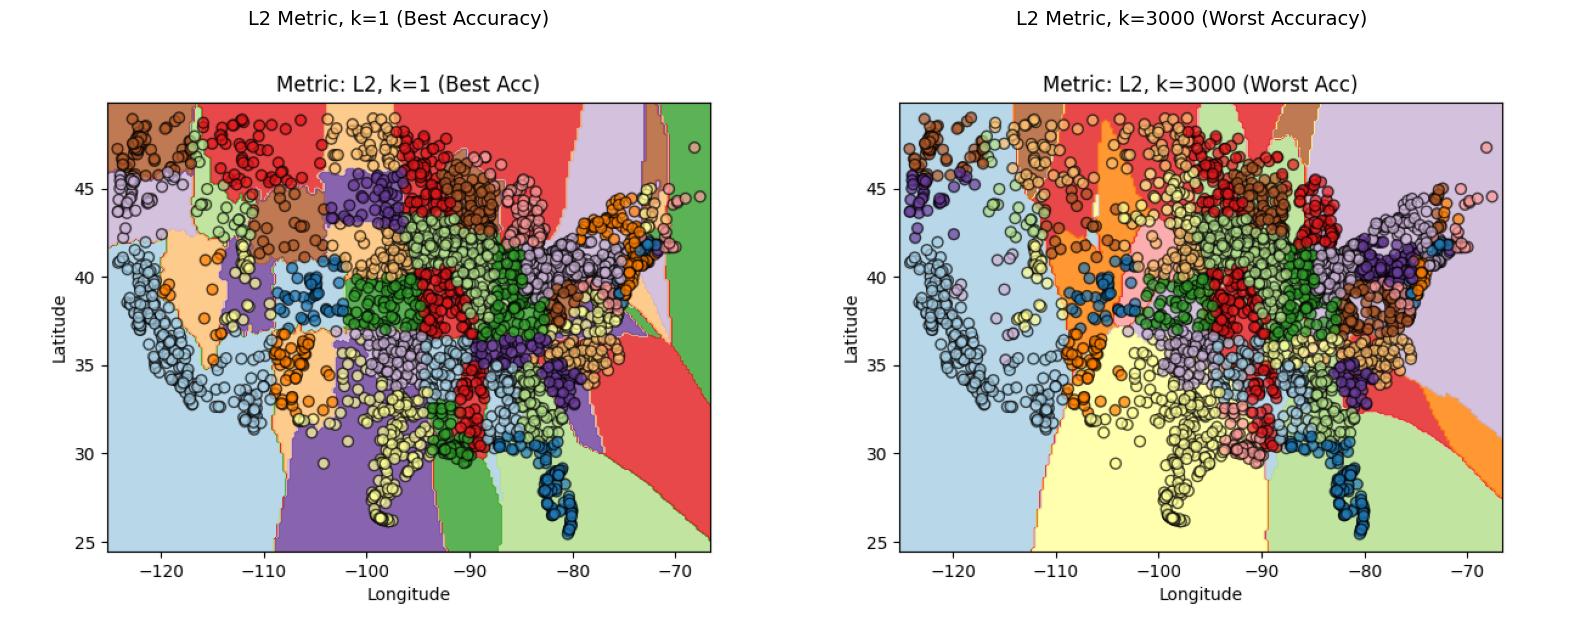

In [15]:
show_comparison(
    'boundares_l2_k1.png',    'L2 Metric, k=1 (Best Accuracy)',
    'boundares_l2_k3000.png', 'L2 Metric, k=3000 (Worst Accuracy)'
)

we see much larger boundaries for L2. any small state gets 'overwhelmed' by the neighbours because the model has to find 3000 cities for the prediciton.

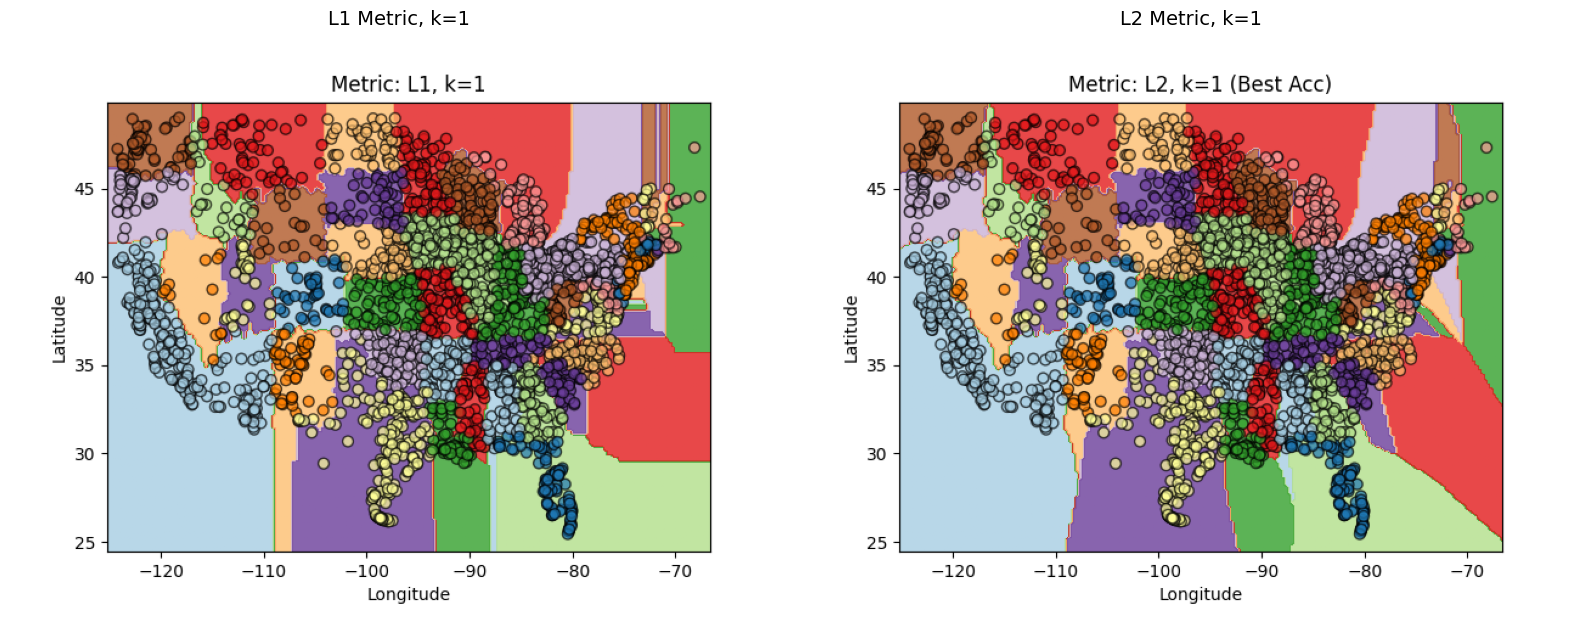

In [16]:

show_comparison(
    'boundares_l1_k1.png', 'L1 Metric, k=1',
    'boundares_l2_k1.png', 'L2 Metric, k=1'
)

in L1 the boundaries tend to be smooth lines. the difference seems mostly in the 'empty' spaces. especially in the bottom left.

## Anomaly detection

**Task:** Use AD_test.csv as test set, train.csv as single class (ignore labels).
1. Find 5 nearest neighbors (L2 distance) for each AD_test sample
2. Sum the 5 distances = anomaly score per sample
3. Select top 50 samples with highest scores = anomalies, rest = normal
4. Plot: AD_test colored by prediction (blue=normal, red=anomaly) + train.csv in black with alpha=0.01

**Question:** What characterizes the anomalies? How do they differ from normal data?

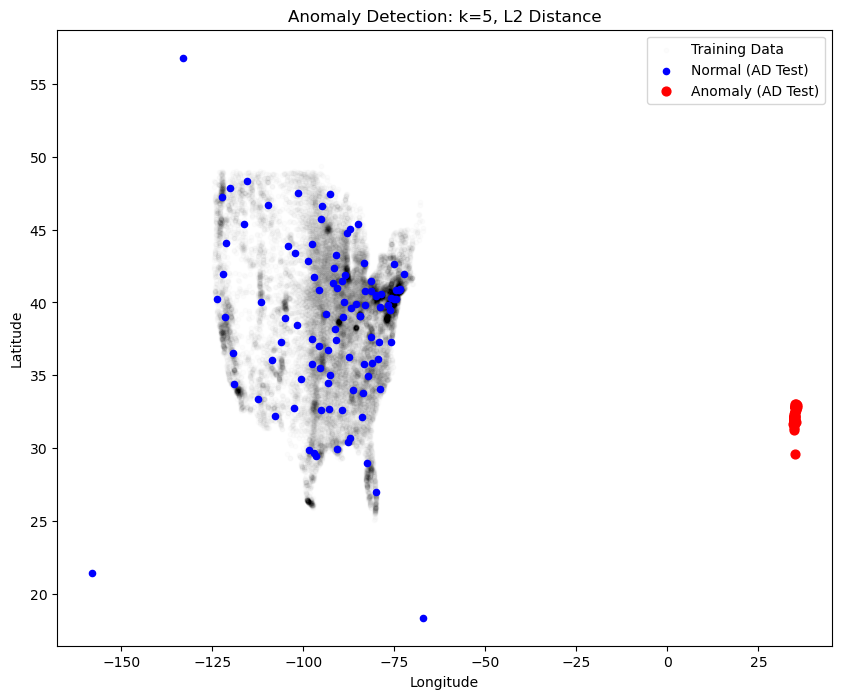

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the data
# Assuming train_data is already loaded from previous steps. 
# If not, uncomment: train_data, _ = read_data_demo('train.csv')
X_train = train_data[:, :2] # Use only features (columns 0 and 1)

# Load AD_test.csv
ad_test_data, _ = read_data_demo('AD_test.csv')
X_ad = ad_test_data[:, :2] # Features only

# 2. Initialize and Fit KNN
# We use k=5 and L2 distance as requested
knn_ad = KNNClassifier(k=5, distance_metric='l2')

# We fit on the training data (labels don't matter here, so we pass dummy labels or the original ones)
knn_ad.fit(X_train, train_data[:, 2]) 

# 3. Calculate Distances
# The knn_distance method in your class returns the distances
distances = knn_ad.knn_distance(X_ad)


# 4. Calculate Anomaly Score (Sum of 5 distances)
anomaly_scores = np.sum(distances, axis=1)

# 5. Identify Top 50 Anomalies

top_50_indices = np.argsort(anomaly_scores)[-50:]

# Create a mask or boolean array for plotting
is_anomaly = np.zeros(len(X_ad), dtype=bool)
is_anomaly[top_50_indices] = True

# 6. Visualization
plt.figure(figsize=(10, 8))

# Plot Train data (Background density) - indesx 0 is latitude, index 1 is longitude
plt.scatter(X_train[:, 0], X_train[:, 1], c='black', s=10, alpha=0.01, label='Training Data')

# Plot Normal AD_test points 
plt.scatter(X_ad[~is_anomaly, 0], X_ad[~is_anomaly, 1], c='blue', s=20, label='Normal (AD Test)')

# Plot Anomaly AD_test points
plt.scatter(X_ad[is_anomaly, 0], X_ad[is_anomaly, 1], c='red', s=40, label='Anomaly (AD Test)')

plt.title('Anomaly Detection: k=5, L2 Distance')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

visualing makes it clear the anomalies are outside the US!

In [23]:
# Extract Longitude column (Column 0)
# We use the boolean mask 'is_anomaly' created in the previous step
long_anomalies = X_ad[is_anomaly, 0]
long_normal = X_ad[~is_anomaly, 0]

print("=== LONGITUDE COMPARISON ===")
# 1. Anomalies Statistics
print("\n--- Anomalies (Top 50) ---")
print(f"Sample values (first 10): {np.round(long_anomalies[:10], 4)}")
print(f"Mean: {long_anomalies.mean():.4f}")
print(f"Std:  {long_anomalies.std():.4f}")
# 2. Normal Data Statistics
print("\n--- Normal Data (Rest) ---")
print(f"Sample values (first 10): {np.round(long_normal[:10], 4)}")
print(f"Mean: {long_normal.mean():.4f}")
print(f"Std:  {long_normal.std():.4f}")


=== LONGITUDE COMPARISON ===

--- Anomalies (Top 50) ---
Sample values (first 10): [34.78   35.2066 34.9992 34.8    34.8864 34.65   34.8567 34.7997 34.7667
 34.8333]
Mean: 34.9592
Std:  0.2026

--- Normal Data (Rest) ---
Sample values (first 10): [ -81.313  -118.9174 -119.3379  -82.9719  -97.1215  -84.4816  -98.4127
 -132.9889  -93.0277  -81.535 ]
Mean: -93.2661
Std:  15.3028


# trees

## Understanding trees - interactive exploration

**Goal:** Interact with tree components to understand how predictions work.
- Create a simple tree, examine its structure (tree_.feature, tree_.threshold, tree_.children_left/right, tree_.value)
- Manually trace a prediction path for a sample point
- Understand how tree.predict() navigates the tree structure

**Visualization library:** `sklearn.tree.plot_tree()` or `graphviz` for tree visualization. For more advanced viz, use `dtreeviz` library.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 1. Setup: Use a small subset of data to keep things clean
# We use the first 2 features (Lat/Lon) and the label
X_subset = train_data[:100, :2] 
Y_subset = train_data[:100, 2]

# 2. Create a simple "Toy" Tree
# We limit depth to 2 so we can easily trace it with our eyes
toy_tree = DecisionTreeClassifier(max_depth=2, random_state=42)
toy_tree.fit(X_subset, Y_subset)

print("Toy tree trained successfully.")

Toy tree trained successfully.


In [ ]:
# Tree visualization series placeholder

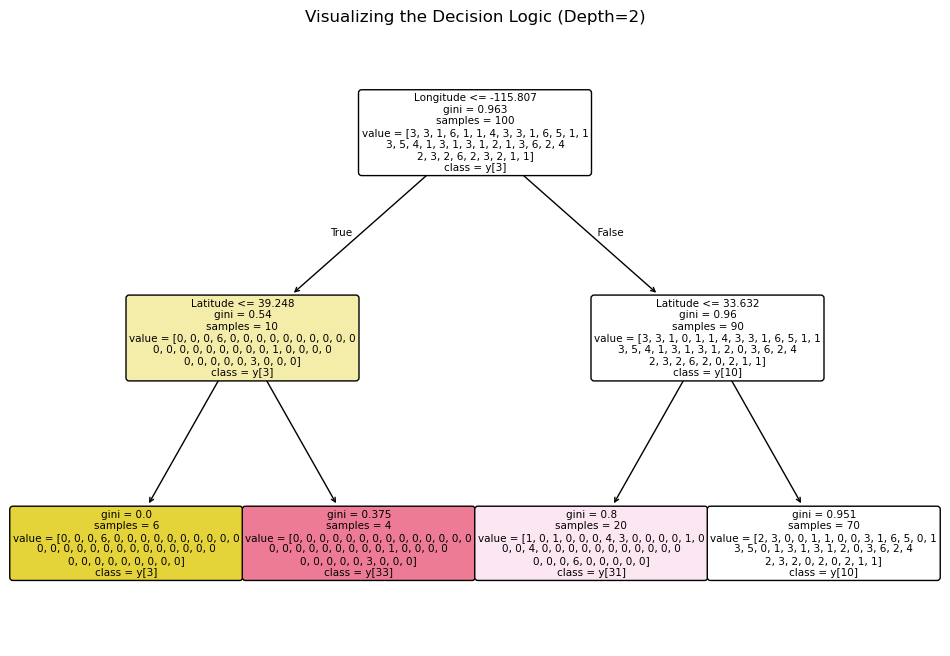

In [25]:
# Visualize the tree logic
plt.figure(figsize=(12, 8))
plot_tree(toy_tree, 
          filled=True, 
          feature_names=['Longitude', 'Latitude'], 
          class_names=True,
          rounded=True)
plt.title("Visualizing the Decision Logic (Depth=2)")
plt.show()

In [26]:
def explore_tree_structure(model, sample_point):
    """
    Manually traces a sample through the decision tree structure.
    """
    # Access the underlying tree object
    tree = model.tree_
    
    # Extract the arrays that define the tree
    # feature: which feature index (0 or 1) to check at this node. -2 indicates a leaf.
    # threshold: the value to compare against.
    # children_left/right: the index of the next node.
    feature = tree.feature
    threshold = tree.threshold
    children_left = tree.children_left
    children_right = tree.children_right
    values = tree.value # The counts of samples per class in that node
    
    print("-" * 30)
    print(f"Tracing sample point: {sample_point}")
    print("-" * 30)

    node_id = 0 # Start at the root
    depth = 0
    
    while True:
        # Check if we are at a leaf node
        # In sklearn, a feature index of -2 (TREE_UNDEFINED) means it is a leaf
        if feature[node_id] == -2:
            print(f"--> Arrived at LEAF Node {node_id}")
            
            # value is an array of counts [class_0_count, class_1_count, ...]
            class_counts = values[node_id][0] 
            predicted_class_index = np.argmax(class_counts)
            
            print(f"    Class distribution at leaf: {class_counts}")
            print(f"    Manual Prediction: Class {predicted_class_index}")
            break
            
        # If not a leaf, decide which way to go
        feat_idx = feature[node_id]
        thresh = threshold[node_id]
        sample_val = sample_point[feat_idx]
        
        feature_name = "Longitude" if feat_idx == 0 else "Latitude"
        
        print(f"Node {node_id} (Depth {depth}):")
        print(f"  Rule: Is {feature_name} ({sample_val:.4f}) <= {thresh:.4f}?")
        
        if sample_val <= thresh:
            print("    YES -> Go Left")
            node_id = children_left[node_id]
        else:
            print("    NO  -> Go Right")
            node_id = children_right[node_id]
            
        depth += 1
        print("")

# --- Execute the Trace ---

# Pick a random sample from the test set to trace
sample_idx = 0
sample = X_test[sample_idx] # Make sure X_test is defined from your previous cells

# 1. Run Manual Trace
explore_tree_structure(toy_tree, sample)

# 2. Run Official Prediction for verification
official_pred = toy_tree.predict([sample])[0]
print("-" * 30)
print(f"Sklearn Official Predict: Class {official_pred}")

------------------------------
Tracing sample point: [-99.9292  31.9564]
------------------------------
Node 0 (Depth 0):
  Rule: Is Longitude (-99.9292) <= -115.8073?
    NO  -> Go Right

Node 4 (Depth 1):
  Rule: Is Latitude (31.9564) <= 33.6323?
    YES -> Go Left

--> Arrived at LEAF Node 5
    Class distribution at leaf: [0.05 0.   0.05 0.   0.   0.   0.2  0.15 0.   0.   0.   0.   0.05 0.
 0.   0.   0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.3  0.   0.   0.   0.   0.  ]
    Manual Prediction: Class 31
------------------------------
Sklearn Official Predict: Class 40.0


Extract the arrays that define the tree
**feature**: which feature index (0 or 1) to check at this node. -2 indicates a leaf.
toy_tree.tree_.feature -> `array([ 0,  1, -2, -2,  1, -2, -2], dtype=int64)`

the structure is clear: root checks feature 0, left and right children check feature 1 (latitude).

**threshold**: the value to compare against.
```
toy_tree.tree_.threshold
array([-115.80725098,   39.24810028,   -2.        ,   -2.        ,
         33.63225174,   -2.        ,   -2.        ])
```

the threshold param holds the value at each node. 
hence, the comaprison is:

```
        feat_idx = feature[node_id]
        thresh = threshold[node_id]
        sample_val = sample_point[feat_idx]
        if sample_val <= thresh:
            print("    YES -> Go Left")
```

### summary

each level of the tree passses another straight line through the feature space, deviding it into two additional subspaces. 
at each level, the tree searches for the line that maximally reduces number of classes per box (reduce gini). 

Eventually, the tree stops splitting a specific box. This happens if:
- The box is "pure" (only contains one state). (gini = 0 -> pure). 
- We reached max_depth.
- We don't have enough samples left to justify a split (min_samples_leaf).

When it stops, that box becomes a Leaf.


note that there are two params here:
the `max_depth` (how many devisions) and `max_leaf_nodes` (how many leaves in the entire tree). 

bottom line:
trees devide feature space into rectangles, and majority vote in the rectangle. 
a tee can never recognise more classes than there are leaves. 

## train 24 trees

**Task:** Train DecisionTreeClassifier for all combinations of max_depth ∈ {1, 2, 4, 6, 10, 20, 50, 100} × max_leaf_nodes ∈ {50, 100, 1000}. Save all 24 models with their hyperparameters (max_depth, max_leaf_nodes) and accuracies (train, validation, test).

In [27]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from helpers import read_data_demo, plot_decision_boundaries

# 1. Load Data
# Assuming files are in the local directory as per your 'ls' command
train_data, _ = read_data_demo('train.csv')
val_data, _ = read_data_demo('validation.csv')
test_data, _ = read_data_demo('test.csv')

X_train, Y_train = train_data[:, :2], train_data[:, 2]
X_val, Y_val = val_data[:, :2], val_data[:, 2]
X_test, Y_test = test_data[:, :2], test_data[:, 2]

# 2. Define Hyperparameters
depths = [1, 2, 4, 6, 10, 20, 50, 100]
leaves = [50, 100, 1000]

results = []
saved_models = {} # Dictionary to store { (depth, leaf) : model_object }

print("Starting Grid Search...")

for d in depths:
    for l in leaves:
        # Initialize and Train
        dt = DecisionTreeClassifier(max_depth=d, max_leaf_nodes=l, random_state=42)
        dt.fit(X_train, Y_train)
        
        # Calculate Accuracies
        train_acc = dt.score(X_train, Y_train)
        val_acc = dt.score(X_val, Y_val)
        test_acc = dt.score(X_test, Y_test)
        
        # Store results
        results.append({
            'max_depth': d,
            'max_leaf_nodes': l,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'test_acc': test_acc
        })
        
        # Save the actual model for plotting later
        saved_models[(d, l)] = dt

# Create DataFrame for analysis
df_trees = pd.DataFrame(results)
print("Done.")

Starting Grid Search...
Done.


In [28]:
# Sort by test_acc descending
df_sorted = df_trees.sort_values(by='test_acc', ascending=False)

# Display the top 10 rows
df_sorted.head(10)

,max_depth,max_leaf_nodes,train_acc,val_acc,test_acc
23,100,1000,1.000000,0.980360,0.978362
20,50,1000,1.000000,0.980360,0.978362
17,20,1000,1.000000,0.980360,0.978362
22,100,100,0.951146,0.942410,0.931425
19,50,100,0.951146,0.942410,0.931425
16,20,100,0.951146,0.942410,0.931425
14,10,1000,0.942408,0.931092,0.922437
13,10,100,0.926636,0.918109,0.911451
21,100,50,0.855062,0.844541,0.835885
18,50,50,0.855062,0.844541,0.835885


In [29]:
df_trees['gap']  = df_trees['train_acc']-df_trees['test_acc']
df_trees

,max_depth,max_leaf_nodes,train_acc,val_acc,test_acc,gap
0,1,50,0.113270,0.113515,0.113515,-0.000245
1,1,100,0.113270,0.113515,0.113515,-0.000245
2,1,1000,0.113270,0.113515,0.113515,-0.000245
3,2,50,0.189339,0.186085,0.189081,0.000258
4,2,100,0.189339,0.186085,0.189081,0.000258
5,2,1000,0.189339,0.186085,0.189081,0.000258
6,4,50,0.362906,0.357190,0.357190,0.005716
7,4,100,0.362906,0.357190,0.357190,0.005716
8,4,1000,0.362906,0.357190,0.357190,0.005716
9,6,50,0.592776,0.580226,0.582224,0.010552


## tree analysis

**Questions:**
1. Report test accuracy of tree with best validation accuracy
2. Does this tree generalize well? Is validation set sufficient for selection?
3. Are 50 leaf nodes enough for perfect accuracy with 50 states? Why/why not?
4. Visualize decision boundaries for best tree from Q1. What shapes do classes form?
5. Find best tree with exactly 50 leaf nodes. Visualize and compare to Q1 best tree.
6. Find best tree with max_depth ≤ 6. Visualize and compare space division to Q4.

In [30]:
# 1. Best Tree Overall (Based on Validation Accuracy)
best_overall_row = df_trees.sort_values(by='val_acc', ascending=False).iloc[0]

best_tree_model = saved_models[(best_overall_row['max_depth'], best_overall_row['max_leaf_nodes'])]
tree_idx = best_overall_row.name
print(f"--- Q1: Best Overall Tree --- at index {tree_idx}")
print(f"Params: Depth={best_overall_row['max_depth']}, Leaves={best_overall_row['max_leaf_nodes']}")
print(f"Validation Acc: {best_overall_row['val_acc']:.4f}")
print(f"Test Acc: {best_overall_row['test_acc']:.4f}")
print('hence, the tree generalised well')

--- Q1: Best Overall Tree --- at index 23
Params: Depth=100.0, Leaves=1000.0
Validation Acc: 0.9804
Test Acc: 0.9784
hence, the tree generalised well


comapring validation vs test

In [31]:
# Select the columns of interest and check correlation
cols = ['train_acc', 'val_acc', 'test_acc']

corr_matrix = df_trees[cols].corr(); print(corr_matrix)
mean_gap, gap_std = df_trees['gap'].mean(),df_trees['gap'].std(),
print(f'for each tree, the mean and std of generalisation gap was {mean_gap} and {gap_std}')

           train_acc   val_acc  test_acc
train_acc   1.000000  0.999952  0.999994
val_acc     0.999952  1.000000  0.999950
test_acc    0.999994  0.999950  1.000000
for each tree, the mean and std of generalisation gap was 0.011749802620313457 and 0.008576308178173503


we see that training and test accuracy as just as correleated at training and val, indicating that val is an equally good estamte of generalisation, and they are alomost perfectly correlated with each other. this is as expected for large data, where we didn't select any model based on val. 

### are 50 leaves enough?

each level of the tree passses another straight line through the feature space, dividing it into two additional subspaces. 
at each level, the tree searches for the line that maximally reduces number of classes per box (reduce gini), and at leaf nodes it predicts most common class in the rectangle. the number of recatngels a tree can create is `min(2**depth, max_leaves)`. 
to be able to predict N classes, a tree beed to have at **at least N** leaves. but that is only sufficient if the data could be perfectly divided by exactly N rectangles. this is only the case if each class was completely concave. since this isn't the case (ie, state borders aren't smooth lines), more than 50 leaves will be needed. 


### how trees see

Plotting Q4: Best Overall Tree...


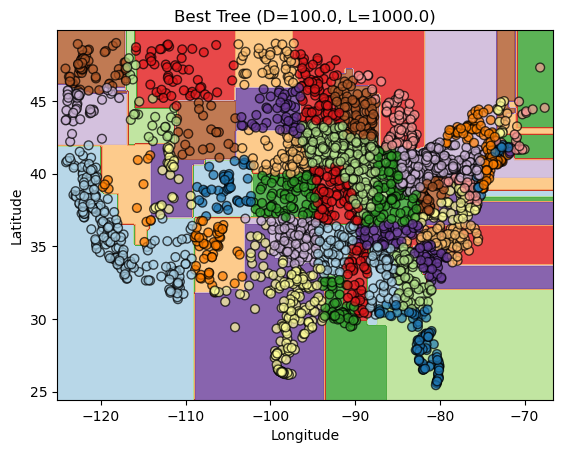

In [32]:
# Q4: Visualize Best Overall Tree
print("Plotting Q4: Best Overall Tree...")
plot_decision_boundaries(best_tree_model, X_test, Y_test, 
                         title=f"Best Tree (D={best_overall_row['max_depth']}, L={best_overall_row['max_leaf_nodes']})")

as expected, it has devided the map into rectangles. 

### 50 leaf prediciton

In [34]:
# 2. Best Tree with Restricted Leaves (max_leaf_nodes = 50)
df_50_leaves = df_trees[df_trees['max_leaf_nodes'] == 50]
best_50_row = df_50_leaves.sort_values(by='val_acc', ascending=False).iloc[0]
best_50_model = saved_models[(best_50_row['max_depth'], best_50_row['max_leaf_nodes'])]

print(f"\n--- Q5: Best Tree with 50 Leaves ---")
print(f"Params: Depth={best_50_row['max_depth']}")
print(f"Validation Acc: {best_50_row['val_acc']:.4f}")


--- Q5: Best Tree with 50 Leaves ---
Params: Depth=20.0
Validation Acc: 0.8445


Plotting Q5: Restricted Leaves (50)...


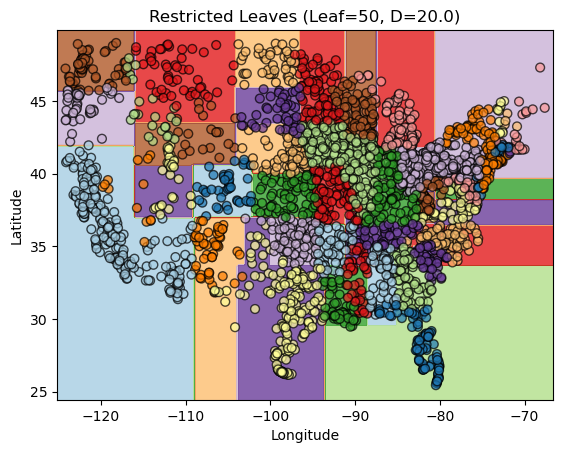

In [35]:
# Q5: Visualize Restricted Leaves (50)
print("Plotting Q5: Restricted Leaves (50)...")
plot_decision_boundaries(best_50_model, X_test, Y_test, 
                         title=f"Restricted Leaves (Leaf=50, D={best_50_row['max_depth']})")

Tracing path for sample #3 (Class: 29.0)...
  Node 0: Longitude > -116.00
  Node 2: Latitude > 33.70
  Node 6: Longitude <= -80.51
  Node 9: Longitude <= -87.54
  Node 11: Longitude <= -91.11
  Node 13: Latitude <= 43.50
  Node 23: Latitude <= 40.58
  Node 31: Longitude <= -94.62
  Node 35: Latitude <= 37.00
  Node 37: Longitude <= -100.08
  Node 45: Longitude > -109.04
  Node 70: Longitude <= -103.04


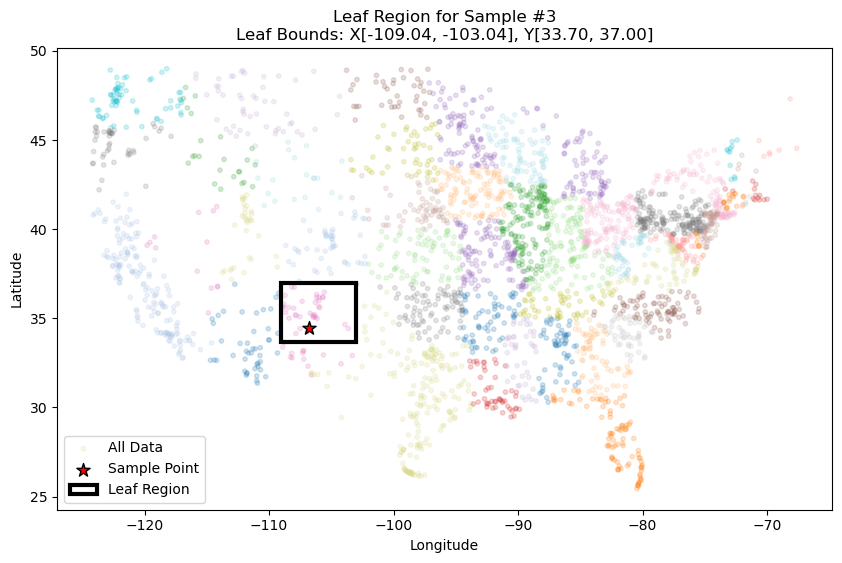

In [39]:


# --- Usage Example ---

# Pick a random index from the test set
sample_idx = 3 

# Use the best_tree_model we found earlier (or any trained model)
visualize_leaf_box(best_50_model, X_test, Y_test, sample_idx)

In [41]:
# 3. Best Tree with Restricted Depth (max_depth <= 6)
df_shallow = df_trees[df_trees['max_depth'] <= 6]
best_shallow_row = df_shallow.sort_values(by='val_acc', ascending=False).iloc[0]
best_shallow_model = saved_models[(best_shallow_row['max_depth'], best_shallow_row['max_leaf_nodes'])]

print(f"\n--- Q6: Best Tree with Depth <= 6 ---")
print(f"Params: Depth={best_shallow_row['max_depth']}, Leaves={best_shallow_row['max_leaf_nodes']}")
print(f"Validation Acc: {best_shallow_row['val_acc']:.4f}")


--- Q6: Best Tree with Depth <= 6 ---
Params: Depth=6.0, Leaves=50.0
Validation Acc: 0.5802


In [42]:
# Rows = max_depth, Columns = max_leaf_nodes, Values = test_acc
pivot_table = df_trees.pivot(index='max_depth', columns='max_leaf_nodes', values='test_acc')
# Use a heatmap style background to instantly spot the best values
pivot_table.style.background_gradient(cmap='viridis')

max_leaf_nodes,50,100,1000
max_depth,,,
1,0.113515,0.113515,0.113515
2,0.189081,0.189081,0.189081
4,0.357190,0.357190,0.357190
6,0.582224,0.582224,0.582224
10,0.831225,0.911451,0.922437
20,0.835885,0.931425,0.978362
50,0.835885,0.931425,0.978362
100,0.835885,0.931425,0.978362


clearly somewhere between depth 6 and 10, there is an optimal 50 recatngles, that can't be imporved by any depth. this indicates that using rectangles (trees) to overlay the boundaries, requires additional leaves to allow perfect prediction. we that even with 100 leaves, there is an upper bound of 0.93 on test accuracy. 


Plotting Q6: Restricted Depth (<=6)...


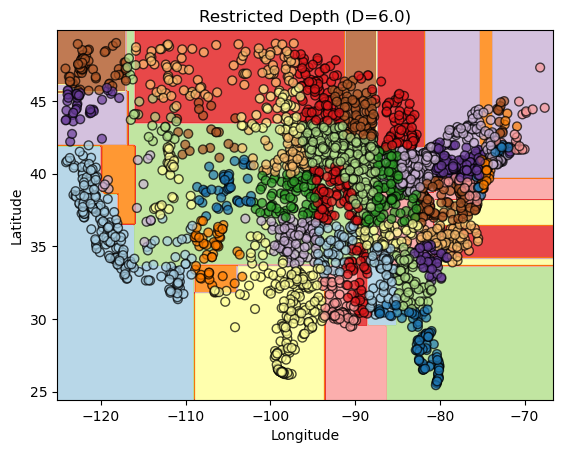

In [43]:
# Q6: Visualize Restricted Depth (<=6)
print("Plotting Q6: Restricted Depth (<=6)...")
plot_decision_boundaries(best_shallow_model, X_test, Y_test, 
                         title=f"Restricted Depth (D={best_shallow_row['max_depth']})")

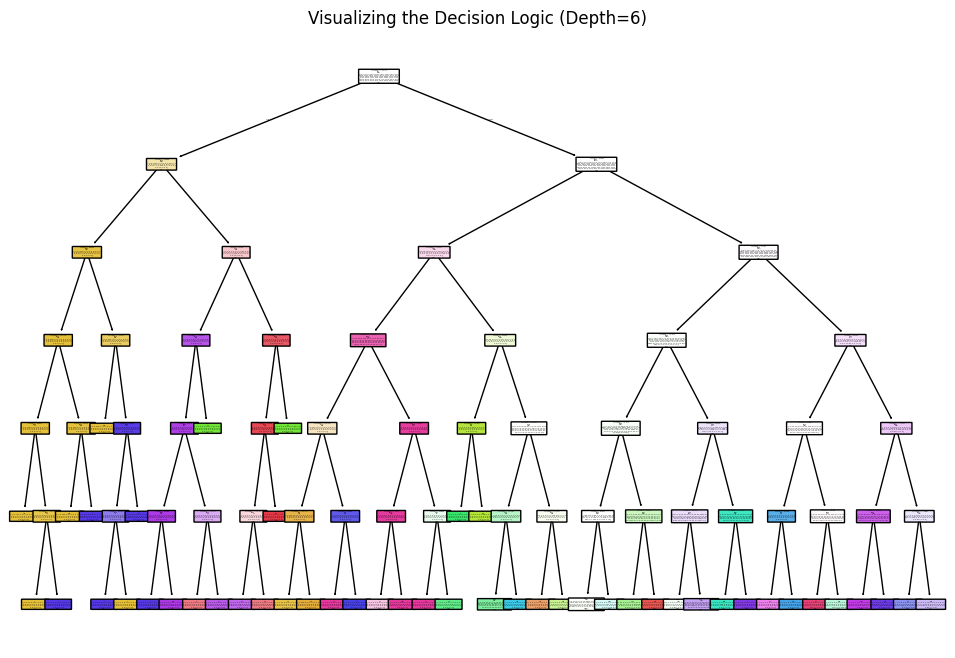

In [95]:

best_shallow_model

plt.figure(figsize=(12, 8))
plot_tree(best_shallow_model, 
          filled=True, 
          label ='none',
          feature_names=['Longitude', 'Latitude'], 
          class_names=True,
          rounded=True)
plt.title("Visualizing the Decision Logic (Depth=6)")
plt.show()

in this case, the tree can't reach the limit of 0.83, since with a depth of 6, the tree is limited in how it can devide the data.

## random forest

**Task:** Train RandomForestClassifier with n_estimators=300, max_depth=6. Visualize decision boundaries. 

**Question:** Is this model more expressive than single tree from Q1? How does visualization show this?

Random Forest Accuracy: 0.8043


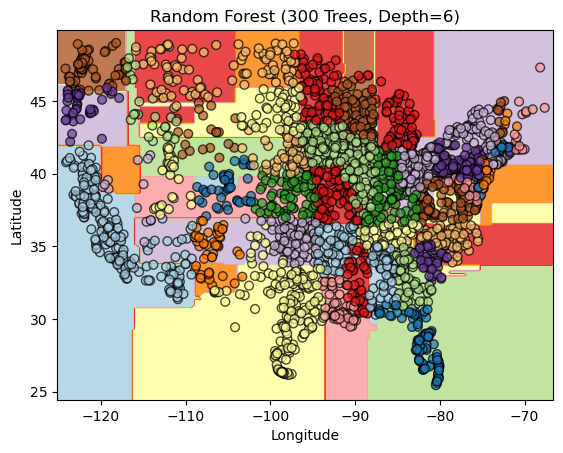

In [54]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1, random_state=42)
rf.fit(X_train, Y_train)

acc_rf = rf.score(X_test, Y_test)
print(f"Random Forest Accuracy: {acc_rf:.4f}")

# Visualize
plot_decision_boundaries(rf, X_test, Y_test, title="Random Forest (300 Trees, Depth=6)")

In [62]:
rf.feature_importances_


array([0.5564807, 0.4435193])

# bonus: boosted trees

**Bonus (5 pts):** Train XGBClassifier with n_estimators=300, max_depth=6, learning_rate=0.1. Report test accuracy and visualize predictions. Compare to random forest: how do predictions differ? Which performs better?

Training XGBoost...
XGBoost Test Accuracy: 0.9650
Plotting XGBoost Boundaries...


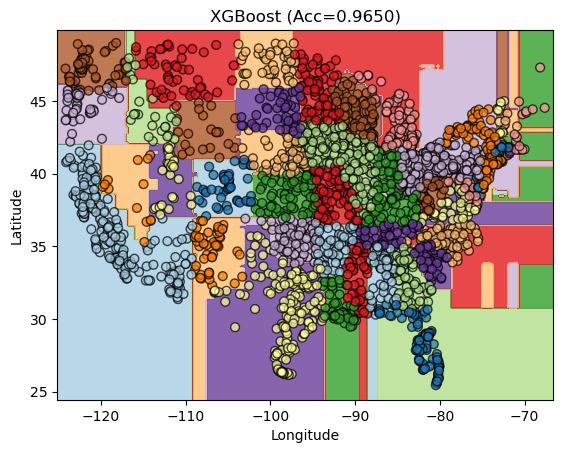

In [46]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from helpers import plot_decision_boundaries

# 1. Prepare Labels for XGBoost (XGB requires 0-indexed integers)
le = LabelEncoder()
Y_train_enc = le.fit_transform(Y_train)
Y_test_enc = le.transform(Y_test)

# 2. Initialize and Train
# params: n_estimators=300, max_depth=6, learning_rate=0.1
xgb_model = XGBClassifier(
    n_estimators=300, 
    max_depth=6, 
    learning_rate=0.1, 
    n_jobs=-1, 
    random_state=42,
    eval_metric='mlogloss' # Prevents warnings
)

print("Training XGBoost...")
xgb_model.fit(X_train, Y_train_enc)

# 3. Report Accuracy
xgb_acc = xgb_model.score(X_test, Y_test_enc)
print(f"XGBoost Test Accuracy: {xgb_acc:.4f}")

# 4. Visualize
print("Plotting XGBoost Boundaries...")
plot_decision_boundaries(xgb_model, X_test, Y_test_enc, 
                         title=f"XGBoost (Acc={xgb_acc:.4f})")

we see that the xgb classifier outperfomrs the RF. I beleive this is due to the differnce in expressivity. the boundaries of the RF 

## interpret Ml explainable boosting classifier

instead of xgb trees, use the glassbox EBM.

In [63]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from helpers import plot_decision_boundaries
le = LabelEncoder()
Y_train_enc = le.fit_transform(Y_train)
Y_test_enc = le.transform(Y_test)
# 1. Initialize and Train EBM
# interactions=10 tells it to look for combinations of features (Lat x Lon)
ebm = ExplainableBoostingClassifier(random_state=42)

print("Training Explainable Boosting Machine...")
ebm.fit(X_train, Y_train_enc)

Training Explainable Boosting Machine...


BrokenProcessPool: A result has failed to un-serialize. Please ensure that the objects returned by the function are always picklable.

In [ ]:
# 2. Accuracy
ebm_acc = ebm.score(X_test, Y_test)
print(f"EBM Test Accuracy: {ebm_acc:.4f}")

# 3. Visualize Decision Boundaries (Compare this to XGBoost/RF)
# Since EBM follows the sklearn API, we can use your existing helper!
print("Plotting EBM Boundaries...")
plot_decision_boundaries(ebm, X_test, Y_test, title=f"EBM (Acc={ebm_acc:.4f})")

In [ ]:
# 4. Global Explanation: How the model works overall
ebm_global = ebm.explain_global()

# This generates an interactive dashboard inside the notebook
show(ebm_global)